# Reinforcement Learning in Finite MDPs

In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

## MDPs

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
from random import *
from cliffwalk import CliffWalk
from test_env import ToyEnv1

Setting up the environment

In [0]:
env = CliffWalk(proba_succ=0.98)

####################################################################################
# You probably want to test smaller enviroments before
#env = ToyEnv1(gamma=0.99)
####################################################################################

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")
print(env.R.shape)

Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [3 2 2 0 3 3 3 2 1 2 0 0 0 2 1 0 0 3 3 0 0 2 0 1 3 2 3 1 1 3 1 3 3 1 2 0 0
 2 0 3 3 3 2 1 2 0 2 3]
(s, a, s', r):
36 0 37 0.6
37 2 36 0.0
36 0 37 0.6
37 2 36 0.0

(48, 4, 48)


## Question 1: Value iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)
3. Evaluate the convergence of your estimate, i.e., plot the value $\|Q_n - Q^\star\|_{\infty} = \max_{s,a} |Q_n(s,a) - Q^\star(s,a)|$

In [0]:
# --------------
# Point 1
# --------------
def bellman_operator(Q0, Ns, Na, R, P, gamma):
  Q1 = np.zeros((Ns,Na))
  greedy_policy = []
  for s in range(Ns):
    for a in range(Na):
      for sx in range(Ns):
        Q1[s,a] = Q1[s,a] + R[s,a,sx]*P[s,a,sx]
      for sn in range(Ns):
        Q1[s,a] = Q1[s,a] + gamma*P[s,a,sn]*np.max(Q0[sn,:])
    greedy_policy.append(np.argmax(Q1[s,:]))
  return Q1, greedy_policy

In [0]:
# --------------
# Point 2
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
    Q_history = [Q0]
    Ns = Q0.shape[0]
    Na =Q0.shape[1]
    Q,greedy_policy = bellman_operator(Q0, Ns, Na, env.R, env.P, env.gamma)
    Q_history.append(Q)
    while np.amax(Q-Q0) > epsilon*np.amax(Q0):
      Q0 = Q
      Q,greedy_policy = bellman_operator(Q0, Ns, Na, env.R, env.P, env.gamma)
      Q_history.append(Q)
    return Q, greedy_policy, Q_history

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

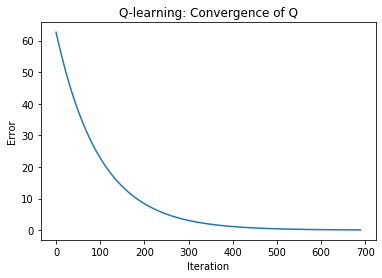

In [0]:
# --------------
# Point 3
# --------------
with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]
Qstar = np.array(Qstar)
Q0 = np.zeros((Qstar.shape[0],Qstar.shape[1]))
Q, greedy_policy, Q_history = value_iteration(Q0, env, epsilon=1e-5)
norm_values = [np.amax(abs(Q_history[i]-Qstar)) for i in range(len(Q_history))]

plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

In [0]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+---------------

## Question 2: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the sum of rewards as a function of iteration


$\epsilon$-greedy policy:
$$
\pi(s) = \begin{cases}
\max_a Q(s,a) & \text{w.p.} \epsilon\\
\text{random action} & \text{w.p.} 1- \epsilon
\end{cases}
$$

We choose $\epsilon = 0.5$ and the learning $rate = \frac{1}{{\#(a_{t},s_{t})}^{0.2}}$ where $\#(a_{t},s_{t})$ is the number of time the agent is in the state $s_{t}$ with the action $a_{t}$. In practice, this learning-rate works.

In [0]:
# ---------------------------
# Q-Learning
# ---------------------------
# suggested interface
# you can change it!
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self,n,tmax,gamma,epsilon,env):
      self.n = n
      self.tmax = tmax
      self.gamma = gamma
      self.epsilon = epsilon
      self.env = env
      self.Q = np.zeros((self.env.Ns,self.env.Na))
      self.V = np.zeros((self.n,self.env.Ns))
      self.cumulative_reward = np.zeros(self.n)
      self.count = np.zeros(((self.env.Ns,self.env.Na)), dtype=int)
    
    def sample_action(self, state):
      x = np.random.binomial(1,self.epsilon)
      return x*np.argmax(self.Q[state,:]) + (1-x)*randint(0,self.env.Na-1)
    
    def update(self, state, action, next_state, reward):
      delta = reward + self.gamma*np.max(self.Q[next_state,:]) - self.Q[state,action]
      self.Q[state,action] = self.Q[state,action] + 1/(self.count[state,action]**0.2)*delta



In [0]:
Q0 = np.zeros((env.Ns, env.Na))
# Use the previous code to verify the correctness of q learning
Q_opt, pi_opt, Qhist_opt = value_iteration(Q0, env, epsilon=1e-8)

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
None
optimal policy:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0]
est policy: [0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 3 3 0 0 0 0 3 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 0]


Text(0.5, 1.0, 'Q-learning: Convergence of Q')

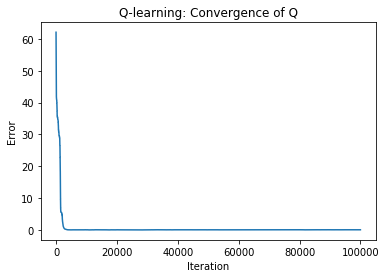

In [0]:
# --------------
# Point 1
# --------------
# Number of Q learning steps
max_steps = int(1e5)  
#max_steps = 10

# main algorithmic loop
ql = QLearning(n=max_steps, tmax=50, gamma=env.gamma, epsilon=0.5, env=env)
norm_values = []
t = 0
tmax = 50
rewardv = np.zeros((max_steps,tmax), dtype=int)
gammas = np.array([env.gamma**k for k in range(tmax)])
for i in range(max_steps):
  state = env.reset()
  for t in range(tmax):
    action = ql.sample_action(state)
    ql.count[state,action] = ql.count[state,action] + 1
    observation, reward, done, info = env.step(action)
    rewardv[i,t] = reward
    ql.update(state, action, observation, reward)
    state = observation
  norm_values.append(np.abs(ql.Q - Q_opt).mean())
  ql.V[i,:] = np.max(ql.Q,axis=1)
  ql.cumulative_reward[i] = ql.cumulative_reward[i-1] + rewardv[i,:].dot(gammas)


    
print(env.render())
print("optimal policy: ", pi_opt)
greedy_policy = np.argmax(ql.Q, axis=1)
print("est policy:", greedy_policy)


plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

# how confident are you in the performance of the algorithm? maybe a single run is not enough

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

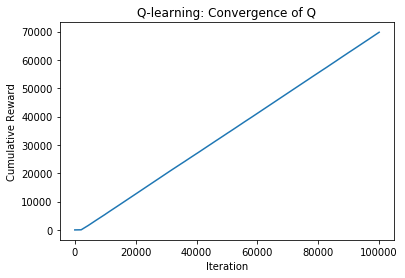

In [0]:
plt.plot(ql.cumulative_reward)
plt.xlabel('Iteration')
plt.ylabel('Cumulative Reward')
plt.title("Q-learning: Convergence of Q")